# Forecasting Singapore's Birth Rate

In [1]:
setwd('C:/Users/User/Downloads/MAEO NOTES/Y3S2/HE3022 Econometric Modelling & Forecasting/Project')
library(readr)
library(fpp2)
library(seasonal)

Warning message:
"package 'fpp2' was built under R version 3.6.2"Loading required package: ggplot2
Loading required package: forecast
Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Registered S3 methods overwritten by 'forecast':
  method             from    
  fitted.fracdiff    fracdiff
  residuals.fracdiff fracdiff
Loading required package: fma
Warning message:
"package 'fma' was built under R version 3.6.2"Loading required package: expsmooth
Warning message:
"package 'expsmooth' was built under R version 3.6.2"Warning message:
"package 'seasonal' was built under R version 3.6.3"

In [2]:
# importing libraries to resize plots
library(repr)
options(repr.plot.width=8, repr.plot.height=4)

In [3]:
# import data from excel
mydata <- readxl::read_xlsx('outputFile.xlsx', sheet = 'T5')

New names:
* `` -> ...2
* `` -> ...3
* `` -> ...4
* `` -> ...5
* `` -> ...6
* ... and 131 more problems


In [4]:
# Extract total birth data from the 6th row
# Remove the first element (name of the row)
# Convert the data to numeric

total_birth <- c()
for (elem in mydata[6,2:ncol(mydata)]){
  total_birth[length(total_birth)+1] <- as.numeric(gsub(",","", elem))
}

# Convert data to timeseries
total_birth_ts <- ts(total_birth, start = 1986, frequency = 4)

In [5]:
# Split the data into training and test set
test <- window(total_birth_ts, start=2014)
training <- head(total_birth_ts, length(total_birth_ts)-length(test))

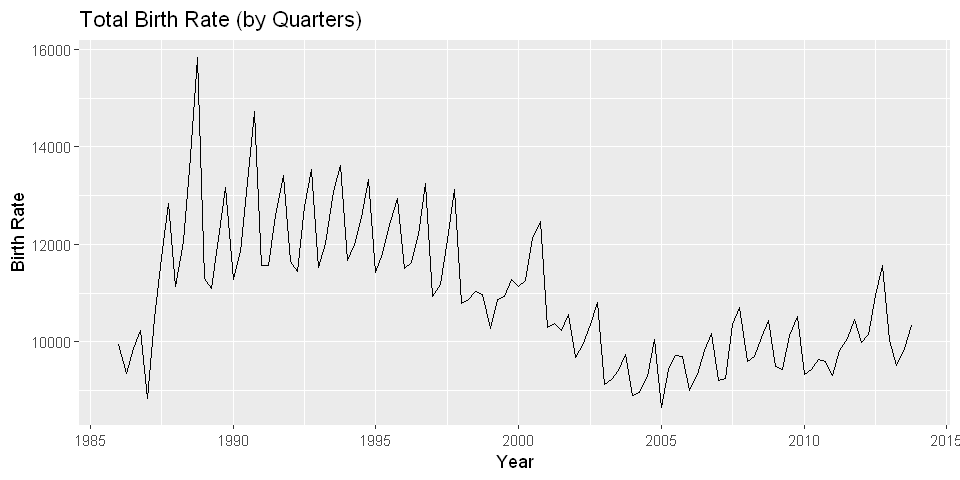

In [6]:
# Plot the data
autoplot(training) + xlab("Year") + ylab("Birth Rate") + 
    ggtitle("Total Birth Rate (by Quarters)")

From the plot, **Birth Rate** seems to exhibit a downward *trend*. 

In addition, the fluctuations suggest the presence of *seasonality*.

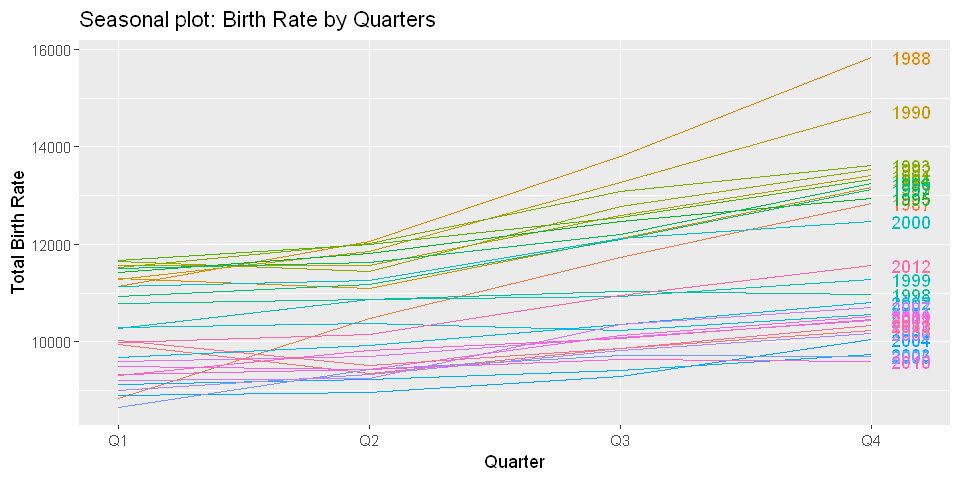

In [118]:
# Seasonal Plot
ggseasonplot(training, year.labels=TRUE, year.labels.left=FALSE) +
  ylab("Total Birth Rate") +
  ggtitle("Seasonal plot: Birth Rate by Quarters")

From the **seasonal plot**, an upward *trend* is observed across the quarters. A seasonal period of 4 should be considered.

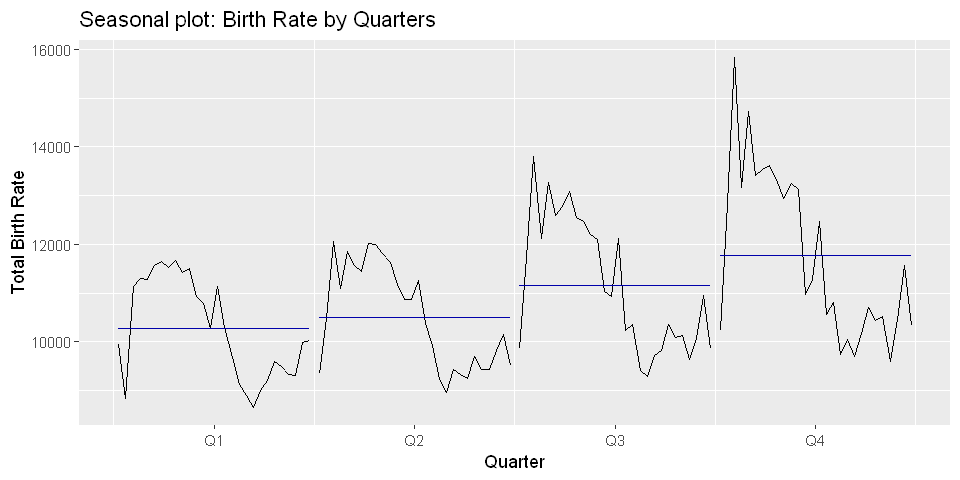

In [119]:
ggsubseriesplot(training) +
  ylab("Total Birth Rate") +
  ggtitle("Seasonal plot: Birth Rate by Quarters")

The **subseries plot** also presented similar results, with increasing mean through the quarters.

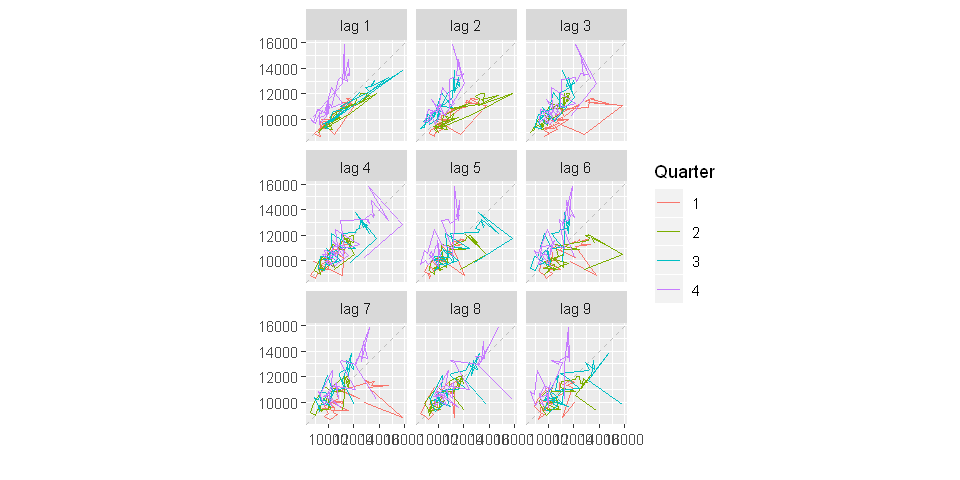

In [120]:
# Lag Plots
gglagplot(total_birth_ts)

The **lag plot** shows a strong positive linear relationship at lag 4 and 8, reflecting strong seasonality.

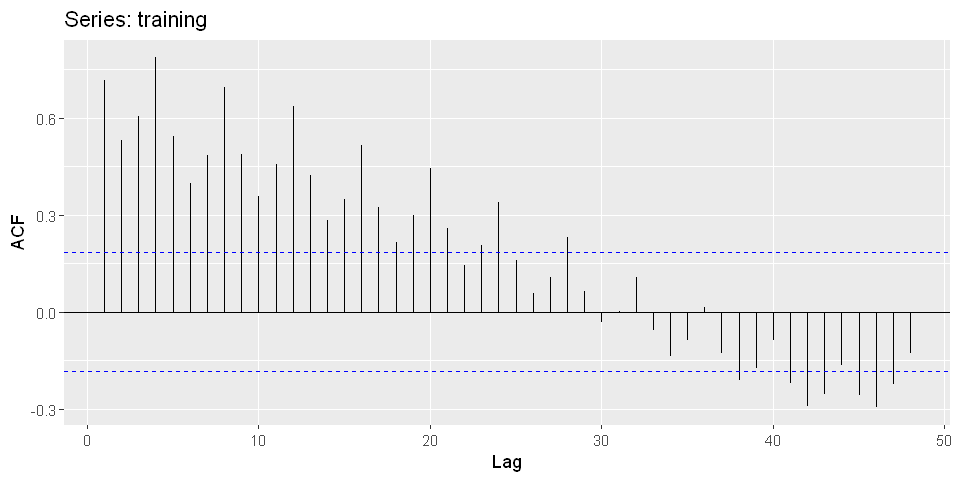

In [10]:
# ACF Plot
ggAcf(training, lag=48)

The slow decrease in the **ACF** plot is due to a *trend* in the series and the "scalloped" shape is due to *seasonality*.

# Decomposition

In this section, the time series data is decomposed into **trend**, **seasonality** and **error**. This will allow us to better understand the characteristics of the series and for us to choose a suitable forecasting model.

The following decomposition method is adopted:
* **Classical** - consist of **Additive** and **Multiplicative** decomposition
* **X11**
* **SEATS**
* **STL**

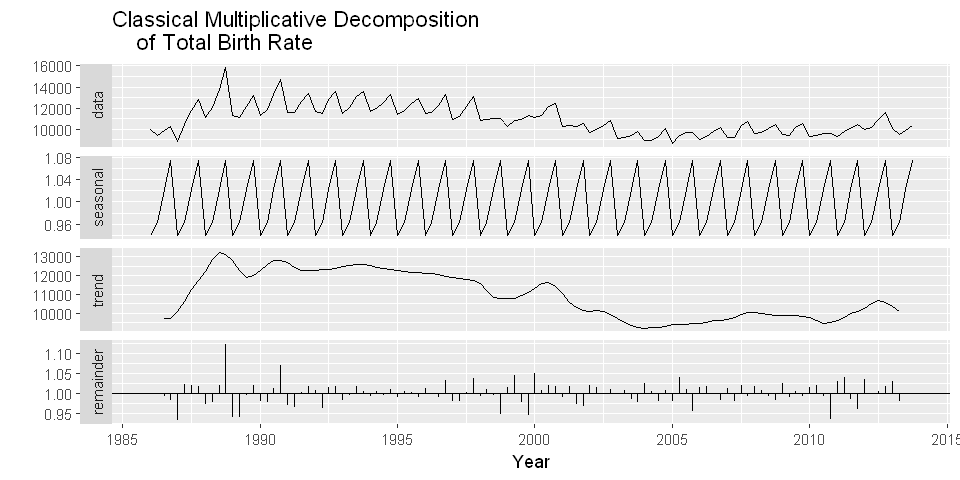

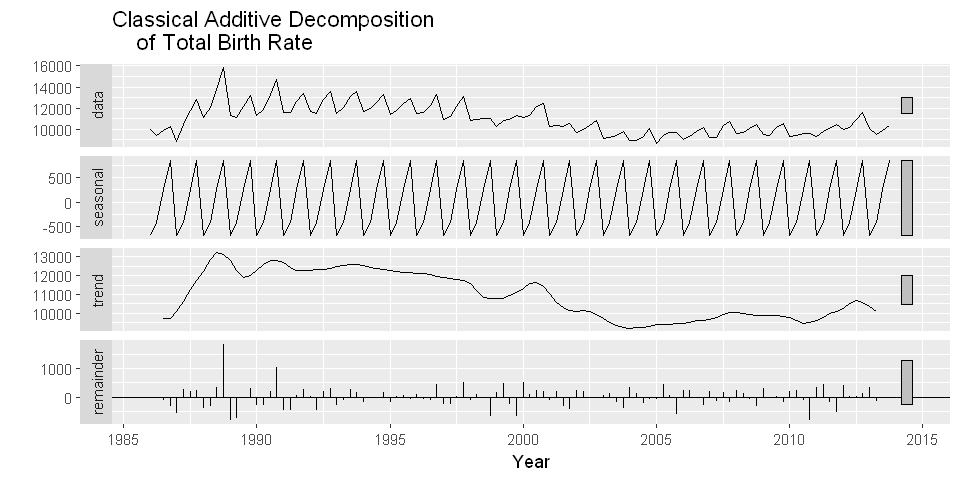

In [121]:
# Classical Decomposition - Multiplicative
training %>% decompose(type="multiplicative") %>%
  autoplot() + xlab("Year") +
  ggtitle("Classical Multiplicative Decomposition
    of Total Birth Rate")

# Classical Decomposition - Additive
training %>% decompose(type="additive") %>%
  autoplot() + xlab("Year") +
  ggtitle("Classical Additive Decomposition
    of Total Birth Rate")

Using **Classical Decomposition**, both **Additive** and **Multiplicative** model exhibits *constant seasonality* and a *downward trend*.

However, the estimates for the first and last few observations are unavailable. 

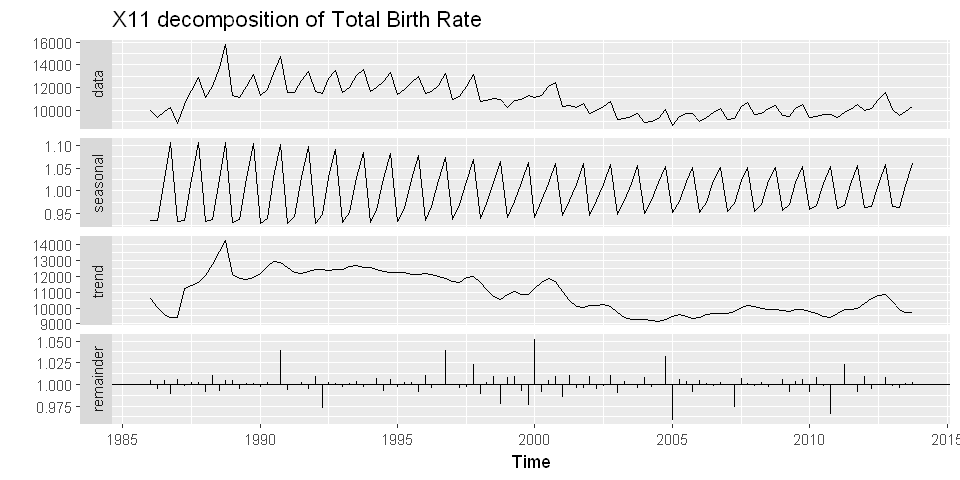

In [122]:
# X11 Decomposition
training %>% seas(x11="") -> fit
autoplot(fit) +
  ggtitle("X11 decomposition of Total Birth Rate")

Using **X11 Decomposition**, the fluctuations in *seasonality* seems to be damping and the *trend* seems to be less smooth as compared to **Classical Decomposition**. All observations are estimated.

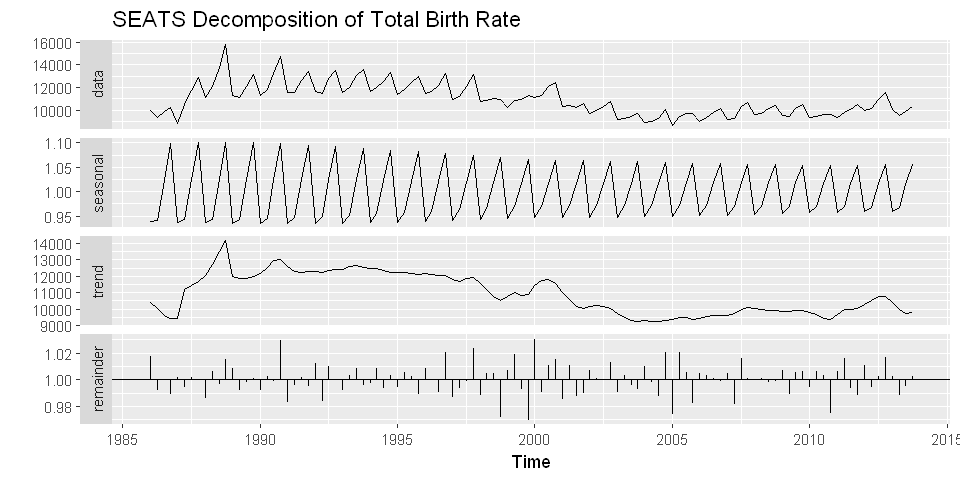

In [123]:
# SEATS Decomposition
training %>% seas() %>%
  autoplot() +
  ggtitle("SEATS Decomposition of Total Birth Rate")

As per the textbook, the results from **SEATS Decomposition** are quite similar to **X11 Decomposition**.

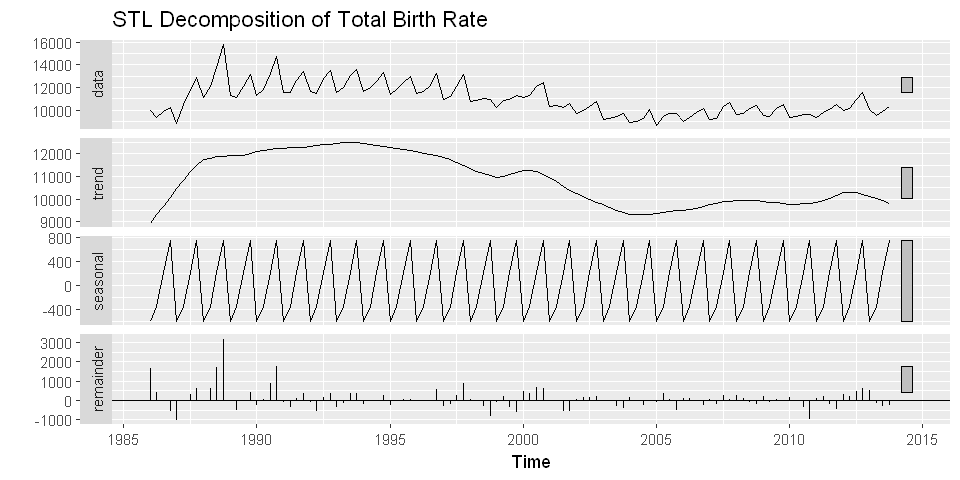

In [124]:
# STL Decomposition
training %>%
  stl(t.window=13, s.window="periodic", robust=TRUE) %>%
  autoplot() + 
  ggtitle("STL Decomposition of Total Birth Rate")

**STL Decomposition** allows for a smoother *trend* and a constant *seasonality*. The degree of *seasonality* seems to be larger than the classical method.

# Forecasting Model

In this section, various forecasting models will be applied to the time series data. The models will then be evaluated in the later section. As **seasonality is present**, only seasonal models will be considered. In addition, damping of trend is not required as birth rates in Singapore shows a **consistent decreasing trend**.

The following simple models will be considered first:
* **Average Method**
* **Seasonal Naive Method**
* **Drift Method** 

Next, the more sophisticated models will be considered:
* **ETS model**
    - **Holt's Winter Seasonal Method** (Additive/Multiplicative)
* **Seasonal ARIMA model**
* **ARDL model**

The following models will not be considered:
* **NNAR model** - this model is more applicable to higher frequency data
* **VAR model** - we are only interested in unilateral relationship between GDP and birth rate

In [52]:
# Average Method
ave <- meanf(training, length(test))
# Seasonal Naive
sna <- snaive(training, length(test))
# Drift Method
drift <- rwf(training, length(test), drift=TRUE)

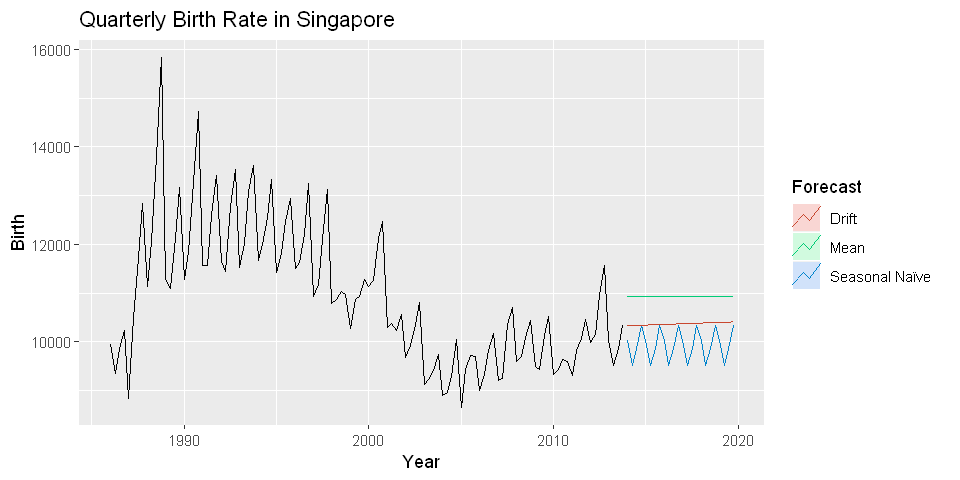

In [126]:
options(repr.plot.width=8, repr.plot.height=4)
autoplot(training) +
  autolayer(meanf(training, length(test)),
    series="Mean", PI=FALSE) +
  autolayer(snaive(training, length(test)),
    series="Seasonal Naïve", PI=FALSE) +
  autolayer(rwf(training, drift=TRUE, length(test)),
    series="Drift", PI=FALSE) +
  ggtitle("Quarterly Birth Rate in Singapore") +
  xlab("Year") + ylab("Birth") +
  guides(colour=guide_legend(title="Forecast"))

The above plot showcase the point forcasts of the simple methods. The **Seasonal Naive** method seems to be the most believeable.

## ETS Model

In [53]:
# Holt-Winters' Seasonal Method
hws_a <- hw(training, seasonal="additive", h=length(test))
hws_m <- hw(training, seasonal="multiplicative", h=length(test))

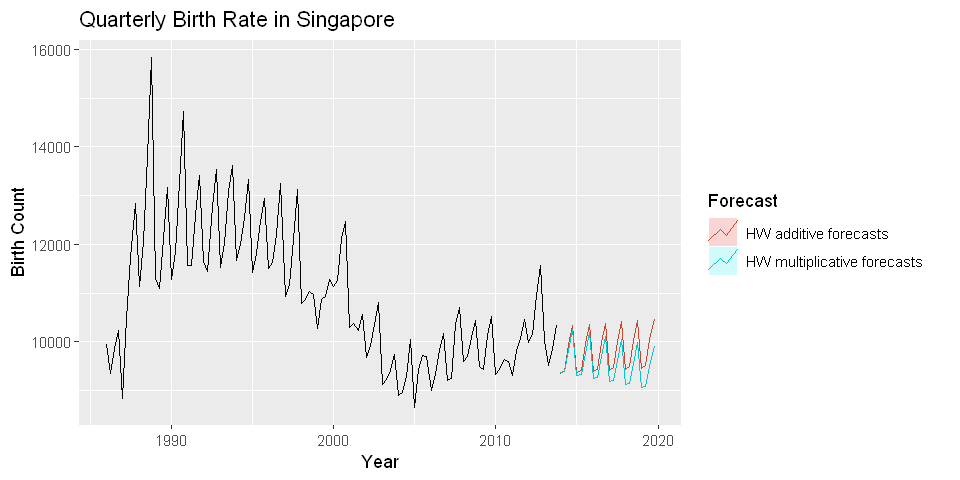

In [182]:
autoplot(training) +
  autolayer(hws_a, series="HW additive forecasts", PI=FALSE) +
  autolayer(hws_m, series="HW multiplicative forecasts",
    PI=FALSE) +
  xlab("Year") +
  ylab("Birth Count") +
  ggtitle("Quarterly Birth Rate in Singapore") +
  guides(colour=guide_legend(title="Forecast"))

The graph above displays 2 different **Holt-Winters' seasonal method** - namely the additive and multiplicative models. The forecasts from the 2 models seem to produce similar results. **Damping of trend** is **not** required as the birth rate exhibits a long-term decreasing trend.

## Seasonal ARIMA Model

Since the series is not stationary, a first differencing will be applied. Next, a seasonal model is adopted to account for the innate seasonality.

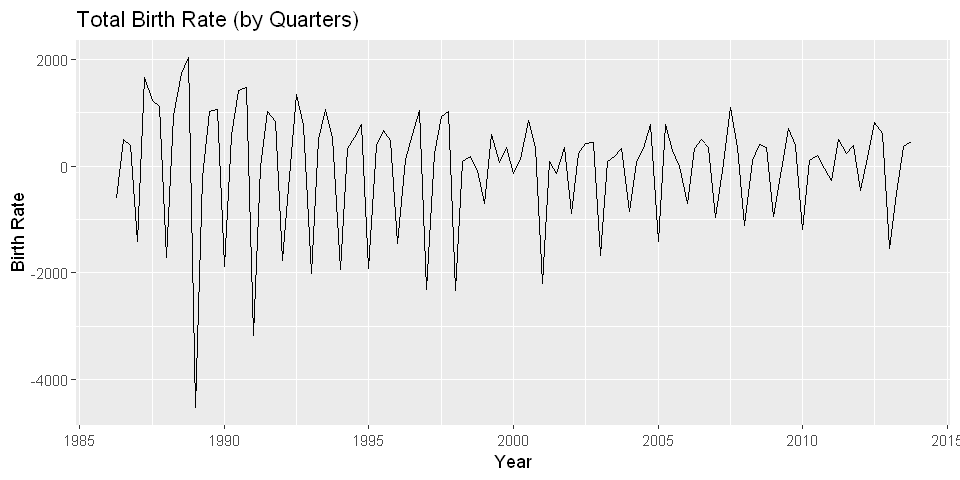

In [54]:
# Plot the first differenced series
autoplot(diff(training)) + xlab("Year") + ylab("Birth Rate") + 
    ggtitle("Total Birth Rate (by Quarters)")

In [130]:
# Check Stationarity (Unit Root Test)
library(urca)
training %>% ur.kpss() %>% summary()


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 4 lags. 

Value of test-statistic is: 1.4131 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


In [21]:
ndiffs(training)

[1] 1

In [22]:
diff(training) %>% ur.kpss() %>% summary()


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 4 lags. 

Value of test-statistic is: 0.0729 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


In [101]:
summary(ur.df(diff(training), lags = 1))


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression none 


Call:
lm(formula = z.diff ~ z.lag.1 - 1 + z.diff.lag)

Residuals:
    Min      1Q  Median      3Q     Max 
-3084.9  -601.8    -0.4   602.4  2983.4 

Coefficients:
           Estimate Std. Error t value Pr(>|t|)    
z.lag.1     -1.7859     0.1278 -13.978  < 2e-16 ***
z.diff.lag   0.5119     0.0830   6.167 1.26e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 915.3 on 107 degrees of freedom
Multiple R-squared:  0.6976,	Adjusted R-squared:  0.6919 
F-statistic: 123.4 on 2 and 107 DF,  p-value: < 2.2e-16


Value of test-statistic is: -13.9784 

Critical values for test statistics: 
      1pct  5pct 10pct
tau1 -2.58 -1.95 -1.62


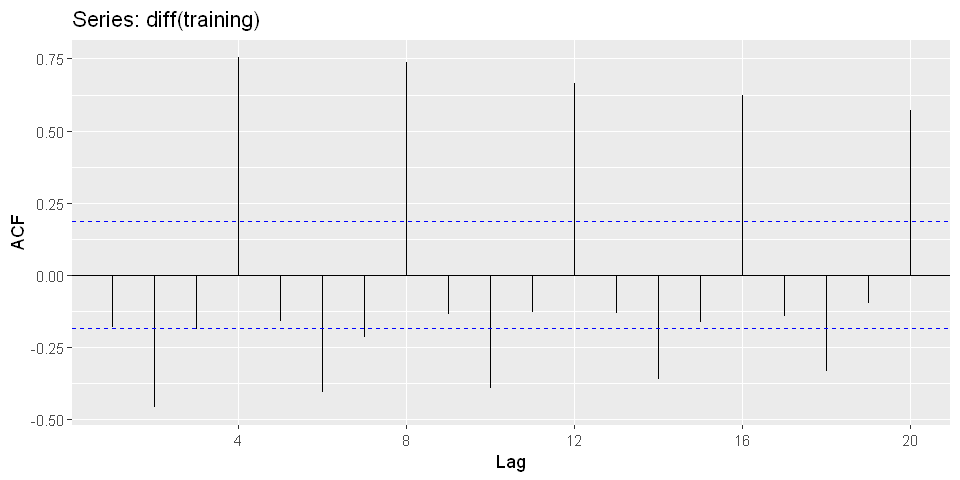

In [77]:
ggAcf(diff(training))

There seems to be strong positive seasonality of period 4.

In [55]:
sarima <- auto.arima(training, seasonal=TRUE)

In [56]:
sarima

Series: training 
ARIMA(1,0,0)(1,1,2)[4] 

Coefficients:
         ar1    sar1     sma1    sma2
      0.8515  0.5691  -1.6579  0.8940
s.e.  0.0558  0.1130   0.2120  0.2591

sigma^2 estimated as 260569:  log likelihood=-830.37
AIC=1670.74   AICc=1671.33   BIC=1684.15

**Seasonal ARIMA** backshift equation:

\begin{equation*}
(1-L)(1-L^4)(1-0.5286L^4) birth_t = (1-1.5904L^4)(1+0.7865L^5)\epsilon_t
\end{equation*}

In [169]:
# SARIMA forecast
sarima_forecast <- forecast(sarima, h = length(test))

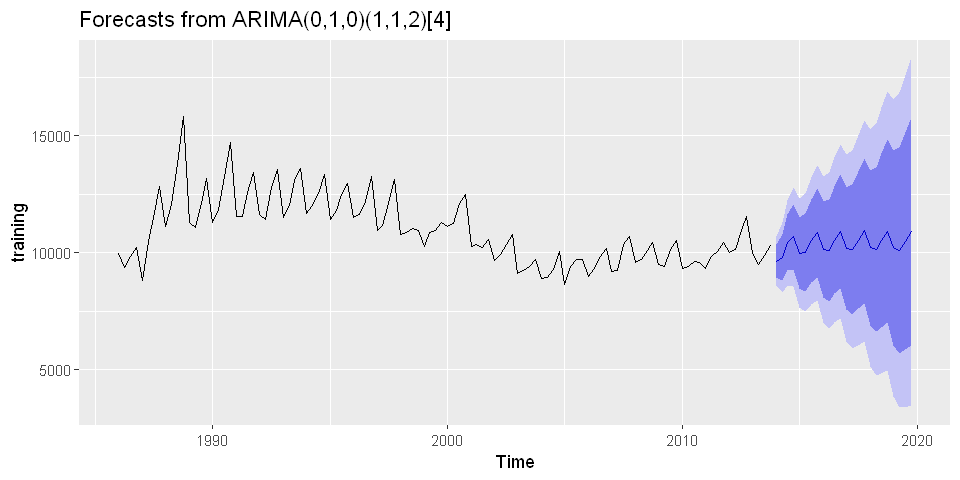

In [134]:
autoplot(sarima_forecast)

## Neural Network Autoregression Model

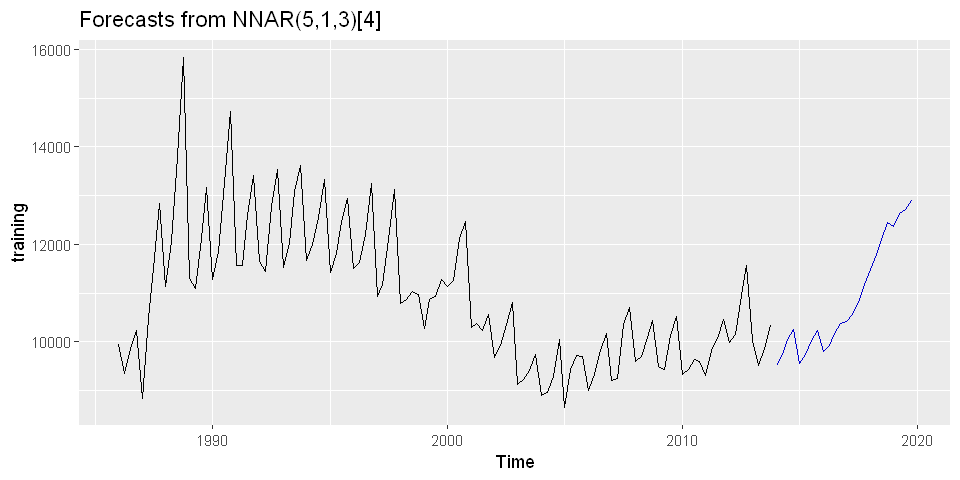

In [57]:
nnar_model <- nnetar(training, lambda=0)
autoplot(forecast(nnar_model,h=length(test)))

## Regression with predictor variables 

In this section, we incorporate **various predictor variables** into our model. As there exists a 9 months lag from pregnancy to birth, the predictor variables should be **lagged by 3 quarters**.

* **Real GDP growth**: Representative of income. As income increases, couples will be more encouraged to have children.
* **Year of the Dragon** (binary): Due to the popular chinese belief that the dragon zodiac is auspicious, more couples tend to choose to have a child during the year of the dragon. 

In [6]:
# import gdp data
mydata1 <- readxl::read_xlsx('GDP.xlsx')

New names:
* `` -> ...2
* `` -> ...3
* `` -> ...4
* `` -> ...5
* `` -> ...6
* ... and 175 more problems


In [8]:
# extract gdp data and convert data to numeric
gdp <- c()
for (elem in mydata1[6,2:ncol(mydata1)]){
    gdp[length(gdp)+1] <- as.numeric(gsub(",","", elem))
}

# convert gdp data to time series data
gdp_ts <- ts(gdp, start=1975 ,frequency=4)

# calculate gdp growth
gdp_growth <- (gdp_ts-lag(gdp_ts,-1))/gdp_ts*100

# subset the timeseries to fit the time period of the birth rate
# the observations are lagged by 3 quarters
gdp_main <- window(gdp_growth, start=1985.25, end = 2019)

# split the series into training and test set
gdp_test <- tail(gdp_main, length(test))
gdp_training <- head(gdp_main, length(training))

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.


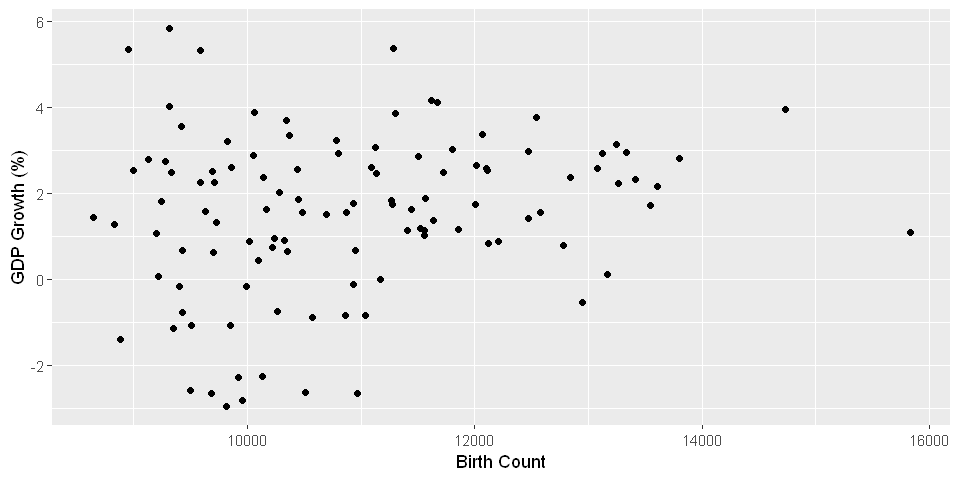

In [8]:
# test for correlation between gdp growth and birth rate
qplot(training, gdp_training) +
  ylab("GDP Growth (%)") + xlab("Birth Count")

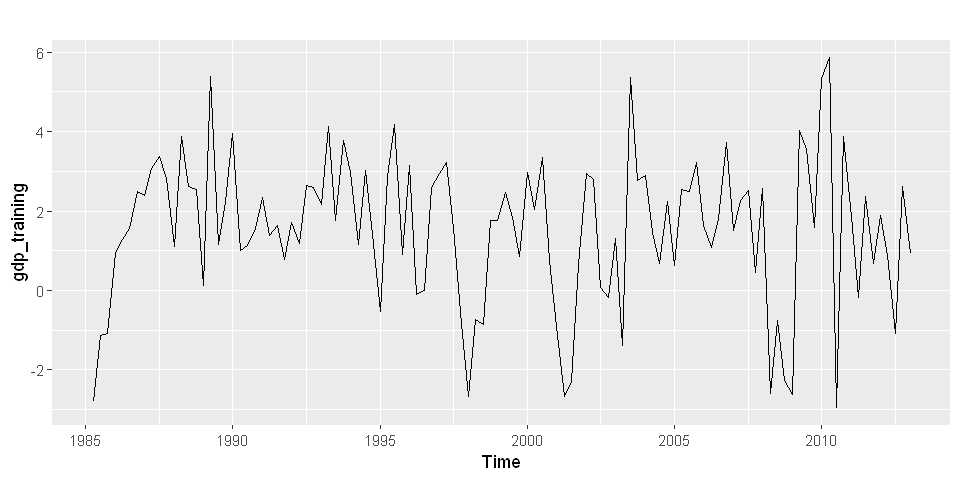

In [22]:
autoplot(gdp_training)

In [81]:
# create input for year of the dragon

# create a vector for 12 years of seasonality
vec <- Reduce(c,list(rep(0,16),rep(1,4),rep(0,28)))
           
# year of the rat starts from 1984
# to get input until 2019
dragon <- ts(c(rep(vec,3)),start=1984,frequency=4)

# subset the timeseries to fit the time period of the birth rate
dragon_main <- window(dragon, start=1986)

# split the series into training and test set
d_test <- window(dragon_main, start=2014)
d_training <- head(dragon_main, length(dragon_main)-length(d_test))

Warning message:
"Removed 3 rows containing non-finite values (stat_density)."Warning message in (function (data, mapping, alignPercent = 0.6, method = "pearson", :
"Removed 6 rows containing missing values"Warning message:
"Removed 6 rows containing missing values (geom_point)."Warning message:
"Removed 3 rows containing non-finite values (stat_density)."

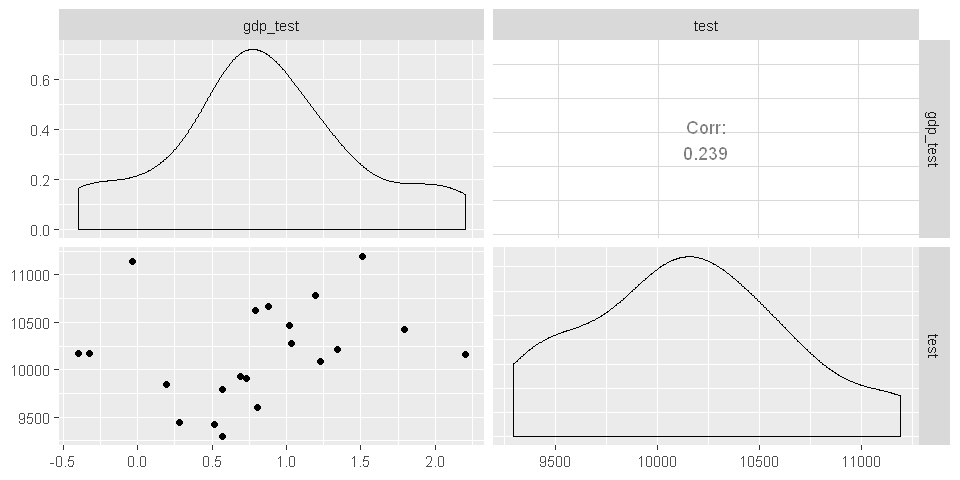

In [84]:
cbind(gdp_test,test) %>%
  as.data.frame() %>%
  GGally::ggpairs()

In [10]:
# introduce a new library for the ARDL model
library(dynamac)

Warning message:
"package 'dynamac' was built under R version 3.6.3"

In [28]:
# check for stationarity in gdp growth
tseries::adf.test(gdp_training)

Warning message in tseries::adf.test(gdp_training):
"p-value smaller than printed p-value"


	Augmented Dickey-Fuller Test

data:  gdp_training
Dickey-Fuller = -5.5417, Lag order = 4, p-value = 0.01
alternative hypothesis: stationary


The null hypothesis is rejected. GDP growth is stationary.

## Simple Linear Regression Model

In [59]:
linear1 <- lm(training ~ gdp_training + d_training)
summary(linear1)


Call:
lm(formula = training ~ gdp_training + d_training)

Residuals:
    Min      1Q  Median      3Q     Max 
-2373.5 -1056.6  -265.3   783.5  4065.4 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  10607.86     172.45  61.512   <2e-16 ***
gdp_training   133.95      69.73   1.921   0.0574 .  
d_training    1005.97     420.41   2.393   0.0184 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1372 on 109 degrees of freedom
Multiple R-squared:  0.08513,	Adjusted R-squared:  0.06834 
F-statistic: 5.071 on 2 and 109 DF,  p-value: 0.007837


**Linear Regression Model**
\begin{equation*}
birth = 10607.86 + 133.95 gdp.growth + 1005.97 dragon + \epsilon
\end{equation*}

**gdp_training** and **d_training** both have positive coeficient. However, **gdp_training** seems to be statistically insignificant.

In [60]:
# input test set data into the regression model
linear_predict <- predict(linear1, newdata=data.frame("gdp_training"=c(gdp_test), "d_training"=c(d_test)))

In [23]:
linear_predict_plot <- ts(linear_predict,start=2014,frequency=4)

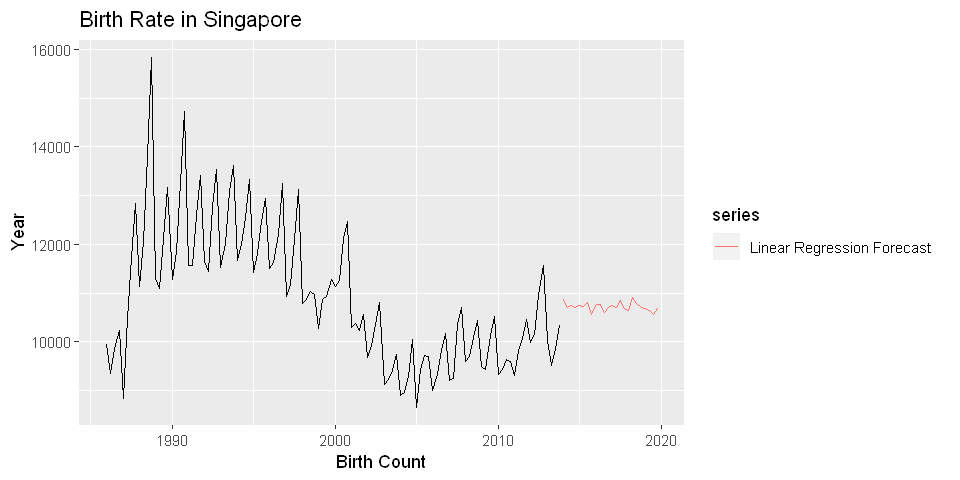

In [26]:
autoplot(training) + autolayer(linear_predict_plot, series = "Linear Regression Forecast") +
    ggtitle("Birth Rate in Singapore") +
    ylab("Year") + xlab("Birth Count")


	Breusch-Godfrey test for serial correlation of order up to 10

data:  Residuals
LM test = 92.866, df = 10, p-value = 1.444e-15


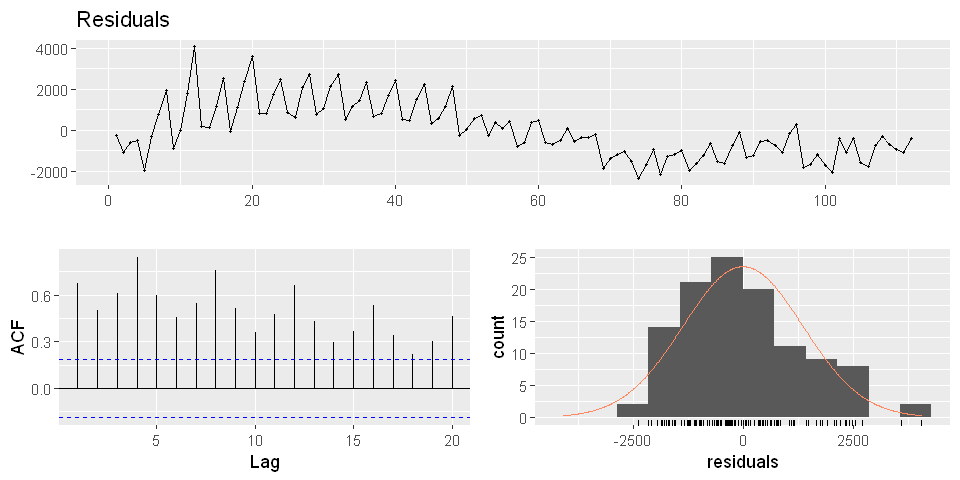

In [68]:
# residual diagnostics
checkresiduals(linear1)

The residual dies down slowly and has a large spike on every 4th lag. This suggest autocorrelation in the error.

## Dynamic Regression

During the estimation of parameters, the sum of square residuals ($\epsilon_t$) is minimised. However, in our linear model above, the sum of squared $n_t$ is minimised instead. This results in several errors such as:

* The estimated coefficient are no longer the best estimates
* Any statistical tests associated with the model is invalid
* The AICc is no longer a good guide to choose the best model
* Most of the time, the p-values associated with the predictor variables are smaller than the actual values. This leads to a "spurrious" regression.

Hence, we apply the **ARIMA model** to $n_t$.

In [68]:
dyn1 <- auto.arima(training, xreg = as.matrix(data.frame("gdp" = gdp_training, "dragon" = d_training)),
                  stationary = TRUE)

In [69]:
dyn1

Series: training 
Regression with ARIMA(2,0,0)(2,0,0)[4] errors 

Coefficients:
         ar1      ar2    sar1    sar2  intercept      gdp     dragon
      0.8618  -0.2229  0.4607  0.4465  10472.008   2.3273  1064.2471
s.e.  0.0998   0.0982  0.0968  0.1019    935.082  16.7323   172.4798

sigma^2 estimated as 240112:  log likelihood=-852.72
AIC=1721.44   AICc=1722.84   BIC=1743.19

**ARIMA Backshift Equation**

\begin{equation*}
birth_t = 10472.0 + 2.33 gdp.growth_t + 1064.2 dragon_t + n_t
\end{equation*}

where

\begin{equation*}
n_t = \frac{1}{(1-0.8618L)(1+0.2229L^2)(1-0.4607L^4)(1-0.4465L^5)}\epsilon_t
\end{equation*}

In [142]:
# forecast with dyn1
dyn1_forecast <- forecast(dyn1, xreg = as.matrix(data.frame("gdp" = gdp_test,"dragon" = d_test)), h = length(test))

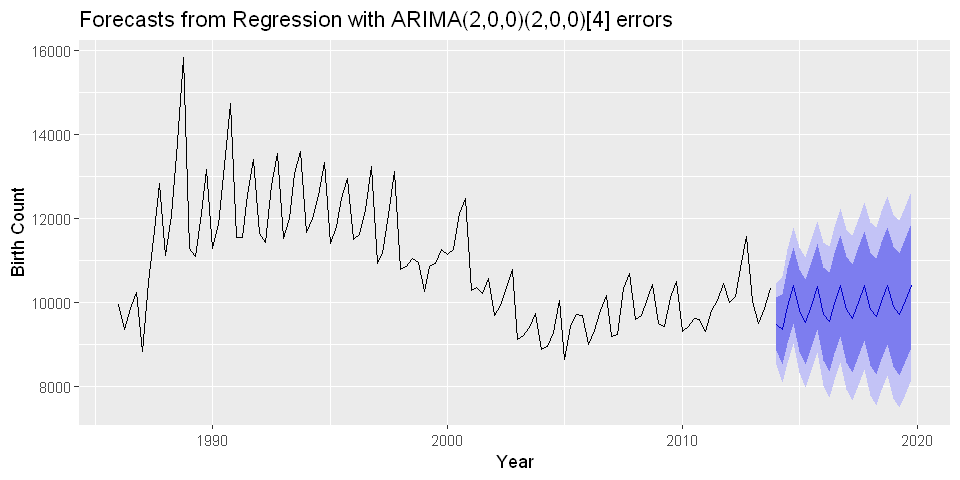

In [143]:
autoplot(dyn1_forecast) + xlab("Year") + ylab("Birth Count")

From the decomposition of the time series, a downward linear trend could be observed. Hence, the next section aims to integrate a linear trend into the model by:

* **Deterministic Trend**
* **Stochastic Trend** (Refer to **Seasonal Arima Model**)

## Dynamic Regression - Deterministic Trend 

In [64]:
# deterministic trend
trend <- seq_along(training)
d_trend <- auto.arima(training, d=0, xreg=trend)

In [65]:
d_trend

Series: training 
Regression with ARIMA(2,0,0)(2,0,0)[4] errors 

Coefficients:
         ar1      ar2    sar1    sar2  intercept     xreg
      0.8911  -0.2096  0.4384  0.4317   11097.40  -8.1703
s.e.  0.0964   0.0973  0.0876  0.0914    1400.69  17.9321

sigma^2 estimated as 322886:  log likelihood=-869.29
AIC=1752.58   AICc=1753.66   BIC=1771.61

**Deterministic Trend Model**

\begin{equation*}
birth_t = 11097.40 - 8.1703t + n_t
\end{equation*}

where,
\begin{equation*}
n_t = \frac{1}{(1-0.8911L)(1+0.2096L^2)(1-0.4384L^4)(1-0.4317L^5)}\epsilon_t
\end{equation*}

In [66]:
d_forecast<- forecast(d_trend, xreg = trend[length(trend)] + seq_along(test), h = length(test))

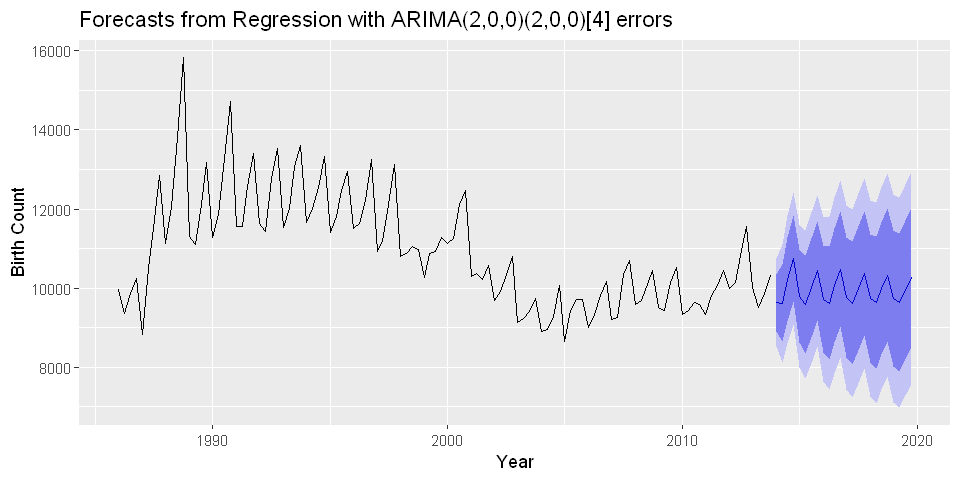

In [34]:
autoplot(d_forecast) + xlab("Year") + ylab("Birth Count")

## Dynamic Regression - Stochastic Trend

In [62]:
s_trend <- auto.arima(training, d=1, seasonal=TRUE)

In [63]:
s_trend

Series: training 
ARIMA(0,1,0)(1,1,2)[4] 

Coefficients:
        sar1     sma1    sma2
      0.5286  -1.5904  0.7865
s.e.  0.1373   0.1145  0.1399

sigma^2 estimated as 288788:  log likelihood=-826.76
AIC=1661.51   AICc=1661.9   BIC=1672.2

**Stochastic Trend Model**

\begin{equation*}
birth_t = birth_{t-1} + \frac{(1-1.5904L^4)(1+0.7865L^5)}{(1-L^4)(1-0.5286L^4)}\epsilon_t 
\end{equation*}

In [37]:
s_forecast <- forecast(s_trend, h = length(test))

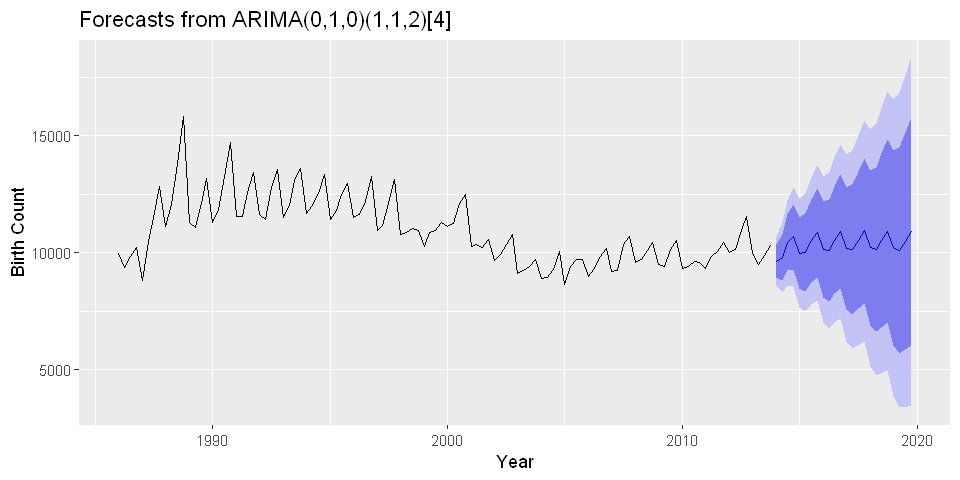

In [39]:
autoplot(s_forecast) + xlab("Year") + ylab("Birth Count")

##  Dynamic Regression - Lagged Predictors

Expanding on the simple linear regression, the impact of **GDP growth** on **Birth Rate** might not be immediate. Hence, the lags of **GDP growth** are also investigated. Models up to lag 4 (4 quarters) are investigated.

In [18]:
# test 0,1,2,3,4 lags

# Lagged predictors. Test 0, 1, 2, 3, 4 lags.
gdp_lag <- cbind(
    gdpLag0 = gdp_training,
    gdpLag1 = stats::lag(gdp_training,-1),
    gdpLag2 = stats::lag(gdp_training,-2),
    gdpLag3 = stats::lag(gdp_training,-3),
    gdpLag4 = stats::lag(gdp_training,-4)) 

In [20]:
# Restrict data so models use same fitting period
fit1 <- auto.arima(training, xreg=gdp_lag[1:length(training),1],
  stationary=TRUE)
fit2 <- auto.arima(training, xreg=gdp_lag[1:length(training),1:2],
  stationary=TRUE)
fit3 <- auto.arima(training, xreg=gdp_lag[1:length(training),1:3],
  stationary=TRUE)
fit4 <- auto.arima(training, xreg=gdp_lag[1:length(training),1:4],
  stationary=TRUE)
fit5 <- auto.arima(training, xreg=gdp_lag[1:length(training),1:5],
  stationary=TRUE)

In [21]:
c(fit1[["aicc"]],fit2[["aicc"]],fit3[["aicc"]],fit4[["aicc"]],fit5[["aicc"]])

[1] 1753.839 1737.181 1722.336 1709.948 1711.793

Fit4 has the smallest AICc value. Hence it is the best model for our training set. Next we will evaluate the model according to forecast accuracy.

In [22]:
fit4

Series: training 
Regression with ARIMA(1,0,1)(2,0,0)[4] errors 

Coefficients:
         ar1     ma1    sar1    sar2  intercept  gdpLag0  gdpLag1  gdpLag2
      0.6132  0.3137  0.4361  0.4513  10314.051  22.6858  42.9054  36.0146
s.e.  0.1273  0.1391  0.0891  0.0933   1147.312  24.1193  30.1357  30.5824
      gdpLag3
      -7.9312
s.e.  24.3961

sigma^2 estimated as 308572:  log likelihood=-843.88
AIC=1707.77   AICc=1710.01   BIC=1734.68

\begin{equation*}
(1-0.61L)(1-L^4)(1-0.44L^4)(1-0.45L^5)birth = 10314.05 + (22.69+42.91L+36.01L^2-7.93L^3)gdp.growth_t + (1+0.31L)\epsilon_t
\end{equation*}

In [34]:
forecast_data <- (data.frame(
    gdpLag0 = gdp_test,
    gdpLag1 = window(gdp_growth, start =2013, end= 2018.75),
    gdpLag2 = window(gdp_growth, start =2012.75, end= 2018.5),
    gdpLag3 = window(gdp_growth, start =2012.5, end= 2018.25))

In [40]:
lagged_predictor_forecast <- forecast(fit4, xreg = as.matrix(forecast_data), h = length(test))

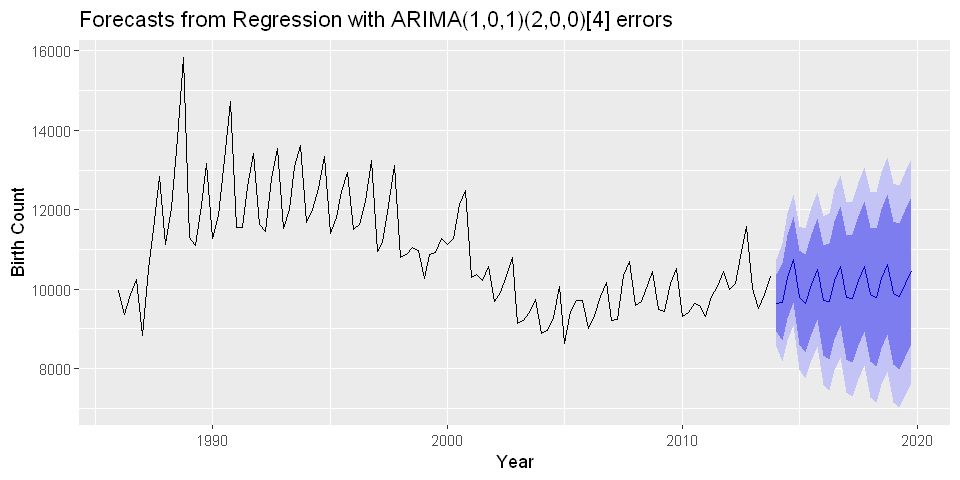

In [48]:
autoplot(lagged_predictor_forecast) + xlab("Year") + ylab("Birth Count")

# Evaluating Forecast Accuracy

In [70]:
# Average Method
ave <- meanf(training, length(test))
# Seasonal Naive
sna <- snaive(training, length(test))
# Drift Method
drift <- rwf(training, length(test), drift=TRUE)

# Holts Winter
hws_a <- hw(training, seasonal="additive", h=length(test))
hws_m <- hw(training, seasonal="multiplicative", h=length(test))

# SARIMA forecast
sarima_forecast <- forecast(sarima, h = length(test))

# NNAR
nnar_forecast<-forecast(nnar_model,h=length(test))

# input test set data into the regression model
linear_predict <- predict(linear1, newdata=data.frame("gdp_training"=c(gdp_test), "d_training"=c(d_test)))

# ARIMA error
dyn1_forecast <- forecast(dyn1, xreg = as.matrix(data.frame("gdp" = gdp_test,"dragon" = d_test)), h = length(test))

# Deterministic trend
d_forecast<- forecast(d_trend, xreg = trend[length(trend)] + seq_along(test), h = length(test))

# Stochastic trend
s_forecast <- forecast(s_trend, h = length(test))

# Lagged predictors
lagged_predictor_forecast <- forecast(fit4, xreg = as.matrix(forecast_data), h = length(test))

In [42]:
RMSE <- function(m,o){sqrt(mean((m-o)^2))}

In [74]:
rmse_data <- c(
    RMSE(ave$mean,test),
    RMSE(sna$mean,test),
    RMSE(drift$mean,test),
    RMSE(hws_a$mean,test),
    RMSE(hws_m$mean,test),
    RMSE(sarima_forecast$mean,test),
    RMSE(linear_predict,test),
    RMSE(dyn1_forecast$mean,test),
    RMSE(d_forecast$mean,test),
    RMSE(s_forecast$mean,test),
    RMSE(lagged_predictor_forecast$mean,test),
    RMSE(nnar_forecast$mean,test)
    )

In [44]:
MAE = function(m,o){mean(abs(m-o))}

In [75]:
mae_data <- c(
    MAE(ave$mean,test),
    MAE(sna$mean,test),
    MAE(drift$mean,test),
    MAE(hws_a$mean,test),
    MAE(hws_m$mean,test),
    MAE(sarima_forecast$mean,test),
    MAE(linear_predict,test),
    MAE(dyn1_forecast$mean,test),
    MAE(d_forecast$mean,test),
    MAE(s_forecast$mean,test),
    MAE(lagged_predictor_forecast$mean,test),
    MAE(nnar_forecast$mean,test)
    )

In [76]:
methods <- c(
    "Average",
    "Seasonal Naive",
    "Drift",
    "Holt's Winter - Additive",
    "Holt's Winter - Multiplicative",
    "Seasonal ARIMA",
    "Simple Linear Regression",
    "Dynamic Regression - ARIMA Error",
    "Dynamic Regression - Deterministic Trend",
    "Dynamic Regression - Stochastic Trend",
    "Dynamic Regression - Lagged Predictors",
    "Neural Network"
    )

In [77]:
forecast_eval <- data.frame("Method" = methods,
                           "RMSE" = rmse_data,
                           "MAE" = mae_data)

In [78]:
forecast_eval

Method,RMSE,MAE
Average,925.0005,814.5179
Seasonal Naive,514.6949,393.4583
Drift,563.5970,461.6881
Holt's Winter - Additive,534.5955,416.8664
Holt's Winter - Multiplicative,669.9337,601.6505
Seasonal ARIMA,651.5513,540.6153
Simple Linear Regression,782.1563,662.9196
Dynamic Regression - ARIMA Error,502.9860,400.1749
Dynamic Regression - Deterministic Trend,406.3712,332.5831
Dynamic Regression - Stochastic Trend,506.9490,450.9119


In [97]:
d_forecast1<- forecast(d_trend, xreg = trend[length(trend)] + seq(length(test)+4), h = length(test)+4)

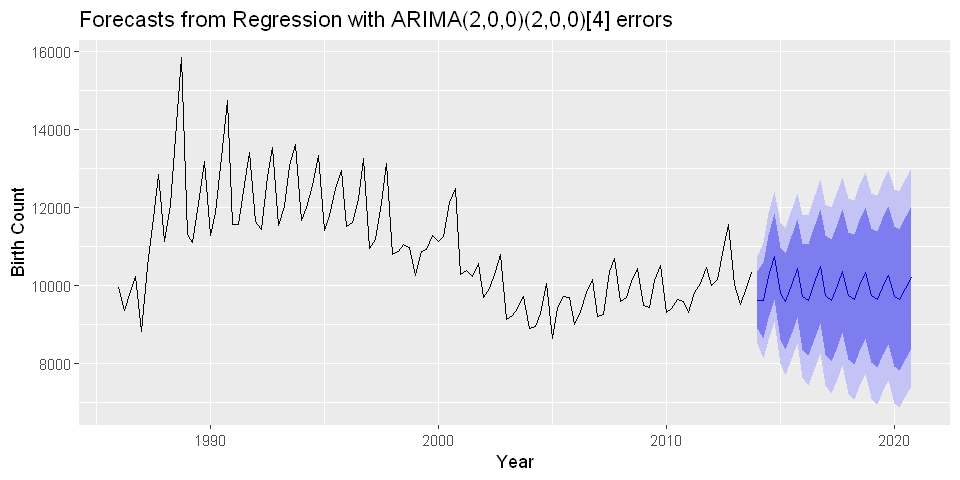

In [101]:
autoplot(d_forecast1) + xlab("Year") + ylab("Birth Count")